# Air Quality and Weather Data Analysis for Hanoi

This notebook extracts hourly air quality data from TimescaleDB and integrates it with weather data from CSV files. We'll ensure all timestamps are in a consistent timezone and format for analysis.

## Import Required Libraries

First, let's import the necessary libraries for our data extraction and processing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pytz
import sys
import os

# Add parent directory to path to import utils
sys.path.append(os.path.abspath('../'))
from utils.timescaledb_util import TimescaleDBUtil

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

## AQI Calculation Functions

We'll define functions to convert individual pollutant measurements to AQI values based on EPA standards.

In [2]:
def calculate_aqi(concentration, pollutant):
    """Calculate AQI value from pollutant concentration
    
    Args:
        concentration: Pollutant concentration
        pollutant: One of 'pm25', 'pm10', 'o3', 'co', 'so2', 'no2'
        
    Returns:
        AQI value
    """
    # Define breakpoints for each pollutant
    # Format: [concentration breakpoints], [corresponding AQI breakpoints]
    breakpoints = {
        'pm25': {
            'conc': [0, 12.0, 35.4, 55.4, 150.4, 250.4, 350.4, 500.4],
            'aqi': [0, 50, 100, 150, 200, 300, 400, 500]
        },
        'pm10': {
            'conc': [0, 54, 154, 254, 354, 424, 504, 604],
            'aqi': [0, 50, 100, 150, 200, 300, 400, 500]
        },
        'o3': {
            'conc': [0, 54, 70, 85, 105, 200, 404, 504],
            'aqi': [0, 50, 100, 150, 200, 300, 400, 500]
        },
        'co': {
            'conc': [0, 4.4, 9.4, 12.4, 15.4, 30.4, 40.4, 50.4],
            'aqi': [0, 50, 100, 150, 200, 300, 400, 500]
        },
        'so2': {
            'conc': [0, 35, 75, 185, 304, 604, 804, 1004],
            'aqi': [0, 50, 100, 150, 200, 300, 400, 500]
        },
        'no2': {
            'conc': [0, 53, 100, 360, 649, 1249, 1649, 2049],
            'aqi': [0, 50, 100, 150, 200, 300, 400, 500]
        }
    }
    
    # Handle missing or invalid data
    if pd.isna(concentration) or concentration < 0:
        return np.nan
    
    # Get breakpoints for the specified pollutant
    if pollutant.lower() not in breakpoints:
        raise ValueError(f"Unsupported pollutant: {pollutant}")
        
    bp = breakpoints[pollutant.lower()]
    conc_breaks = bp['conc']
    aqi_breaks = bp['aqi']
    
    # Find the appropriate breakpoint range
    idx = 0
    while idx < len(conc_breaks) - 1 and concentration > conc_breaks[idx + 1]:
        idx += 1
    
    # Calculate AQI using the formula:
    # AQI = ((I_high - I_low) / (C_high - C_low)) * (C - C_low) + I_low
    # where I is AQI and C is concentration
    c_low = conc_breaks[idx]
    c_high = conc_breaks[idx + 1] if idx < len(conc_breaks) - 1 else conc_breaks[idx]
    i_low = aqi_breaks[idx]
    i_high = aqi_breaks[idx + 1] if idx < len(aqi_breaks) - 1 else aqi_breaks[idx]
    
    # Avoid division by zero
    if c_high == c_low:
        return i_low
    
    aqi = ((i_high - i_low) / (c_high - c_low)) * (concentration - c_low) + i_low
    
    # Round to nearest integer
    return round(aqi)

def calculate_overall_aqi(pollutant_values):
    """Calculate overall AQI from multiple pollutant measurements
    
    Args:
        pollutant_values: Dictionary with pollutant concentrations
            (keys: 'pm25', 'pm10', 'o3', 'co', 'so2', 'no2')
            
    Returns:
        Overall AQI value (maximum of individual AQIs)
    """
    aqi_values = {}
    
    # Calculate AQI for each pollutant
    for pollutant, concentration in pollutant_values.items():
        if pd.notna(concentration):
            try:
                aqi_values[pollutant] = calculate_aqi(concentration, pollutant)
            except Exception as e:
                print(f"Error calculating AQI for {pollutant}: {e}")
    
    # Return maximum AQI value if any are available
    if aqi_values:
        return max(aqi_values.values())
    else:
        return np.nan
    
def get_aqi_category(aqi_value):
    """Get the AQI category based on the AQI value
    
    Args:
        aqi_value: AQI value
        
    Returns:
        AQI category string
    """
    if pd.isna(aqi_value):
        return "Unknown"
    
    if aqi_value <= 50:
        return "Good"
    elif aqi_value <= 100:
        return "Moderate"
    elif aqi_value <= 150:
        return "Unhealthy for Sensitive Groups"
    elif aqi_value <= 200:
        return "Unhealthy"
    elif aqi_value <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

def add_aqi_columns(df):
    """Add AQI calculations to a DataFrame with pollutant measurements
    
    Args:
        df: DataFrame with columns like 'avg_pm25', 'avg_pm10', etc.
        
    Returns:
        DataFrame with added AQI columns
    """
    result_df = df.copy()
    
    # Map from DataFrame column names to pollutant names
    pollutant_map = {
        'avg_pm25': 'pm25',
        'avg_pm10': 'pm10',
        'avg_o3': 'o3',
        'avg_co': 'co',
        'avg_so2': 'so2',
        'avg_no2': 'no2'
    }
    
    # Calculate individual AQI values for each pollutant
    for col, pollutant in pollutant_map.items():
        if col in result_df.columns:
            aqi_col = f'aqi_{pollutant}'
            result_df[aqi_col] = result_df[col].apply(lambda x: calculate_aqi(x, pollutant) if pd.notna(x) else np.nan)
    
    # Calculate overall AQI
    result_df['calculated_aqi'] = result_df.apply(lambda row: calculate_overall_aqi({
        'pm25': row['avg_pm25'] if 'avg_pm25' in row and pd.notna(row['avg_pm25']) else np.nan,
        'pm10': row['avg_pm10'] if 'avg_pm10' in row and pd.notna(row['avg_pm10']) else np.nan,
        'o3': row['avg_o3'] if 'avg_o3' in row and pd.notna(row['avg_o3']) else np.nan,
        'co': row['avg_co'] if 'avg_co' in row and pd.notna(row['avg_co']) else np.nan,
        'so2': row['avg_so2'] if 'avg_so2' in row and pd.notna(row['avg_so2']) else np.nan,
        'no2': row['avg_no2'] if 'avg_no2' in row and pd.notna(row['avg_no2']) else np.nan,
    }), axis=1)
    
    # Add AQI category
    result_df['aqi_category'] = result_df['calculated_aqi'].apply(get_aqi_category)
    
    return result_df

# Test the AQI calculation function
test_data = {
    'pm25': 35, 
    'pm10': 150, 
    'o3': 60, 
    'co': 5, 
    'so2': 40, 
    'no2': 70
}

print("Testing AQI calculations with sample data:")
for pollutant, value in test_data.items():
    aqi = calculate_aqi(value, pollutant)
    category = get_aqi_category(aqi)
    print(f"{pollutant.upper()}: {value} -> AQI: {aqi} ({category})")

overall_aqi = calculate_overall_aqi(test_data)
print(f"\nOverall AQI: {overall_aqi} ({get_aqi_category(overall_aqi)})")

Testing AQI calculations with sample data:
PM25: 35 -> AQI: 99 (Moderate)
PM10: 150 -> AQI: 98 (Moderate)
O3: 60 -> AQI: 69 (Moderate)
CO: 5 -> AQI: 56 (Moderate)
SO2: 40 -> AQI: 56 (Moderate)
NO2: 70 -> AQI: 68 (Moderate)

Overall AQI: 99 (Moderate)


## Connect to TimescaleDB

We'll use the TimescaleDBUtil class to establish a connection to the TimescaleDB database.

In [3]:
# Initialize TimescaleDB connection
# The utility will automatically look for DB_URL in environment variables or .env file
db_util = TimescaleDBUtil()

# Test connection
connection_successful = db_util.connect()
print(f"Database connection {'successful' if connection_successful else 'failed'}")

Database connection successful


## Extract Hourly Air Quality Data

We'll query the TimescaleDB to extract hourly air quality data. We'll use time bucketing to ensure we have hourly data points.

In [4]:
def extract_hourly_air_quality(start_date=None, end_date=None, location=None):
    """Extract hourly air quality data from TimescaleDB
    
    Args:
        start_date: Start date for data extraction (defaults to 7 days ago)
        end_date: End date for data extraction (defaults to now)
        location: Filter by specific station (optional)
        
    Returns:
        DataFrame with hourly air quality data by station
    """
    # Set default dates if not provided
    if not start_date:
        start_date = (datetime.now() - timedelta(days=7)).strftime('%Y-%m-%d')
    if not end_date:
        end_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    # Construct WHERE clause with optional location filter
    where_clause = f"time >= '{start_date}' AND time <= '{end_date}'"
    if location:
        where_clause += f" AND station = '{location}'"
    
    # Define the aggregations we want to perform - preserving station/location information
    aggregations = [
        "station",  # Keep the station as a dimension rather than aggregating
        'AVG("PM2.5") AS avg_pm25',
        'AVG("PM10") AS avg_pm10',
        'AVG("O3") AS avg_o3',
        'AVG("NO2") AS avg_no2',
        'AVG("SO2") AS avg_so2',
        'AVG("CO") AS avg_co'
    ]
    
    # Get hourly data using time_bucket, grouped by station
    air_quality_data = db_util.get_time_bucket_data(
        table_name="air_quality_measurements",
        time_column="time",
        interval="1 hour",
        aggregations=aggregations,
        where_clause=where_clause,
        group_by="station",  # Group by station to preserve granularity
        order_by="time_bucket, station"
    )
    
    # Calculate AQI values if data was retrieved successfully
    if air_quality_data is not None and not air_quality_data.empty:
        air_quality_data = add_aqi_columns(air_quality_data)
        # Rename station to location for consistency with weather data
        air_quality_data.rename(columns={'station': 'location'}, inplace=True)
    
    return air_quality_data

# Get data for the last 30 days (adjust as needed)
start_date = (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d')
air_quality_df = extract_hourly_air_quality(start_date=start_date)

if air_quality_df is not None and not air_quality_df.empty:
    print(f"Successfully retrieved {len(air_quality_df)} hourly air quality records")
    display(air_quality_df.head())


Successfully retrieved 3009 hourly air quality records


,time_bucket,location,location,avg_pm25,avg_pm10,avg_o3,avg_no2,avg_so2,avg_co,aqi_pm25,aqi_pm10,aqi_o3,aqi_co,aqi_so2,aqi_no2,calculated_aqi,aqi_category
0,2025-04-05,46 Lưu Quang Vũ,46 Lưu Quang Vũ,24.66,NaN,NaN,87.23,NaN,NaN,77.0,NaN,NaN,NaN,NaN,86.0,86.0,Moderate
1,2025-04-05,An Khánh,An Khánh,26.60,29.8,NaN,26.00,NaN,223.0,81.0,28.0,NaN,500.0,NaN,25.0,500.0,Hazardous
2,2025-04-05,Minh Khai - Bắc Từ Liêm,Minh Khai - Bắc Từ Liêm,NaN,105.9,31.27,NaN,0.34,1.7,NaN,76.0,29.0,19.0,0.0,NaN,76.0,Moderate
3,2025-04-05,Vân Hà,Vân Hà,35.40,38.9,NaN,10.70,NaN,235.5,100.0,36.0,NaN,500.0,NaN,10.0,500.0,Hazardous
4,2025-04-05,Đào Duy Từ,Đào Duy Từ,22.80,31.5,NaN,39.60,NaN,529.6,73.0,29.0,NaN,500.0,NaN,37.0,500.0,Hazardous


## Load Weather Data from CSV

Now we'll load the weather data from the CSV file and preprocess it.

In [5]:
# Define path to weather data
weather_csv_path = '../result/hanoiweather_all.csv'

# Load weather data
try:
    weather_df = pd.read_csv(weather_csv_path)
    print(f"Successfully loaded weather data with {len(weather_df)} records")
    display(weather_df.head())
except Exception as e:
    print(f"Error loading weather data: {e}")
    # Create empty DataFrame with expected columns
    weather_df = pd.DataFrame(columns=['timestamp', 'weather_icon', 'wind_speed', 'humidity', 'temperature', 'location'])

# Check if data was loaded
if not weather_df.empty:
    # Display weather data info
    print("\nWeather data information:")
    print(weather_df.info())
    
    # Display unique locations
    print(f"\nNumber of unique locations: {weather_df['location'].nunique()}")
    print(f"Sample locations: {', '.join(weather_df['location'].unique()[:5])}")

Successfully loaded weather data with 6364 records


,timestamp,weather_icon,wind_speed,humidity,temperature,location
0,2025-04-30T23:27:15+07:00,mist,9.2 km/h,94%,79°,Phường Phú Thượng
1,2025-04-30T23:27:20+07:00,mist,9.2 km/h,94%,79°,"IQAir UNIS, Phuong Phu Thuong"
2,2025-04-30T23:27:24+07:00,partly-cloudy-day,7.6 km/h,91%,77°,Hà Nội
3,2025-04-30T23:27:29+07:00,partly-cloudy-day,10.5 km/h,90%,79°,"Minh Khai - Bắc Từ Liêm, Hà Nội"
4,2025-04-30T23:27:34+07:00,partly-cloudy-day,9.8 km/h,90%,79°,"Hà Nội: Chi cục BVMT (KK), Hà Nội"



Weather data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   timestamp     6364 non-null   object
 1   weather_icon  6364 non-null   object
 2   wind_speed    6364 non-null   object
 3   humidity      6364 non-null   object
 4   temperature   6364 non-null   object
 5   location      6364 non-null   object
dtypes: object(6)
memory usage: 298.4+ KB
None

Number of unique locations: 71
Sample locations: Phường Phú Thượng, IQAir UNIS, Phuong Phu Thuong, Hà Nội, Minh Khai - Bắc Từ Liêm, Hà Nội, Hà Nội: Chi cục BVMT (KK), Hà Nội


## Preprocess Weather Data

We need to preprocess the weather data to ensure consistent timestamps and units.

In [6]:
def preprocess_weather_data(weather_df):
    """Preprocess weather data for analysis
    
    Args:
        weather_df: DataFrame with weather data
        
    Returns:
        Preprocessed DataFrame
    """
    if weather_df.empty:
        return pd.DataFrame()
    
    # Make a copy to avoid modifying the original DataFrame
    df = weather_df.copy()
    
    # 1. Parse timestamps and convert to datetime objects with timezone info
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    # Convert timezone-aware datetime to timezone-naive to match air quality data
    if hasattr(df['timestamp'].dt, 'tz'):
        df['timestamp'] = df['timestamp'].dt.tz_localize(None)
    
    # 2. Extract numeric values from wind_speed (remove 'km/h')
    df['wind_speed_kmh'] = df['wind_speed'].str.extract(r'(\d+\.?\d*)').astype(float)
    
    # 3. Extract numeric values from humidity (remove '%')
    df['humidity_pct'] = df['humidity'].str.rstrip('%').astype(float)
    
    # 4. Extract numeric values from temperature (remove '°')
    df['temperature_f'] = df['temperature'].str.rstrip('°').astype(float)
    # Convert to Celsius
    df['temperature_c'] = (df['temperature_f'] - 32) * 5/9
    
    # 5. Normalize weather icon values (if needed)
    # Map icon names to standardized categories
    weather_category_map = {
        'mist': 'mist',
        'partly-cloudy-day': 'partly_cloudy',
        'rain': 'rain',
        'ic-w-01-clear-sky-full.svg': 'clear_sky',
        'ic-w-02-new-clouds-full.svg': 'cloudy',
        'ic-w-06-rain-full.svg': 'rain',
        'ic-w-10-night-clear-sky-full.svg': 'clear_night'
    }
    df['weather_category'] = df['weather_icon'].map(lambda x: weather_category_map.get(x, 'other'))
    
    # 6. Extract hour from timestamp for hourly aggregation
    df['timestamp_hour'] = df['timestamp'].dt.floor('H')
    
    # 7. Set all locations to "Hanoi" as per requirement
    df['location'] = "Hanoi"
    
    return df

# Preprocess the weather data
processed_weather_df = preprocess_weather_data(weather_df)

if not processed_weather_df.empty:
    print("Weather data preprocessing complete.")
    display(processed_weather_df.head())
    
    # Show data types and any missing values
    print("\nProcessed weather data information:")
    print(processed_weather_df.info())
    print("\nMissing values in each column:")
    print(processed_weather_df.isnull().sum())

Weather data preprocessing complete.


/var/folders/_h/z2p4js8n69579sq4glntxbww0000gn/T/ipykernel_31071/1926749379.py:47: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['timestamp_hour'] = df['timestamp'].dt.floor('H')


,timestamp,weather_icon,wind_speed,humidity,temperature,location,wind_speed_kmh,humidity_pct,temperature_f,temperature_c,weather_category,timestamp_hour
0,2025-04-30 23:27:15,mist,9.2 km/h,94%,79°,Hanoi,9.2,94.0,79.0,26.111111,mist,2025-04-30 23:00:00
1,2025-04-30 23:27:20,mist,9.2 km/h,94%,79°,Hanoi,9.2,94.0,79.0,26.111111,mist,2025-04-30 23:00:00
2,2025-04-30 23:27:24,partly-cloudy-day,7.6 km/h,91%,77°,Hanoi,7.6,91.0,77.0,25.000000,partly_cloudy,2025-04-30 23:00:00
3,2025-04-30 23:27:29,partly-cloudy-day,10.5 km/h,90%,79°,Hanoi,10.5,90.0,79.0,26.111111,partly_cloudy,2025-04-30 23:00:00
4,2025-04-30 23:27:34,partly-cloudy-day,9.8 km/h,90%,79°,Hanoi,9.8,90.0,79.0,26.111111,partly_cloudy,2025-04-30 23:00:00



Processed weather data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         6364 non-null   datetime64[ns]
 1   weather_icon      6364 non-null   object        
 2   wind_speed        6364 non-null   object        
 3   humidity          6364 non-null   object        
 4   temperature       6364 non-null   object        
 5   location          6364 non-null   object        
 6   wind_speed_kmh    6364 non-null   float64       
 7   humidity_pct      6364 non-null   float64       
 8   temperature_f     6364 non-null   float64       
 9   temperature_c     6364 non-null   float64       
 10  weather_category  6364 non-null   object        
 11  timestamp_hour    6364 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(4), object(6)
memory usage: 596.8+ KB
None

Missing values in eac

## Aggregate Weather Data to Hourly Intervals

We'll aggregate the weather data to hourly intervals to match our air quality data.

In [7]:
def aggregate_weather_to_hourly(processed_weather_df):
    """Aggregate weather data to hourly intervals
    
    Args:
        processed_weather_df: Preprocessed weather DataFrame
        
    Returns:
        DataFrame with hourly aggregated weather data for Hanoi
    """
    if processed_weather_df.empty:
        return pd.DataFrame()
    
    # Group by hour, then aggregate (all data now has location="Hanoi")
    hourly_weather = processed_weather_df.groupby(['timestamp_hour']).agg({
        'temperature_c': 'mean',
        'humidity_pct': 'mean',
        'wind_speed_kmh': 'mean',
        'weather_category': lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown',
        'location': 'first'  # All values should be "Hanoi"
    }).reset_index()
    
    # Rename timestamp_hour to match air quality data's time_bucket column
    hourly_weather.rename(columns={'timestamp_hour': 'time_bucket'}, inplace=True)
    
    return hourly_weather

# Aggregate weather data to hourly intervals
hourly_weather_df = aggregate_weather_to_hourly(processed_weather_df)

if not hourly_weather_df.empty:
    print(f"Successfully aggregated weather data to {len(hourly_weather_df)} hourly records.")
    display(hourly_weather_df.head())
    
    # Show distribution of weather categories
    weather_category_counts = hourly_weather_df['weather_category'].value_counts()
    print("\nDistribution of weather categories:")
    display(weather_category_counts)

Successfully aggregated weather data to 100 hourly records.


,time_bucket,temperature_c,humidity_pct,wind_speed_kmh,weather_category,location
0,2025-04-30 23:00:00,25.538721,92.424242,8.306061,partly_cloudy,Hanoi
1,2025-05-01 00:00:00,25.529101,91.396825,8.134921,partly_cloudy,Hanoi
2,2025-05-01 01:00:00,25.503472,91.953125,7.642187,partly_cloudy,Hanoi
3,2025-05-01 02:00:00,25.476190,91.523810,6.258730,partly_cloudy,Hanoi
4,2025-05-01 03:00:00,24.664903,94.888889,5.079365,partly_cloudy,Hanoi



Distribution of weather categories:


weather_category
partly_cloudy    67
other             9
clear_night       8
rain              7
cloudy            6
clear_sky         3
Name: count, dtype: int64

## Merge Air Quality and Weather Data

Now we'll merge the hourly air quality and weather data based on timestamp.

In [8]:
def merge_air_quality_and_weather(air_quality_df, hourly_weather_df):
    """Merge air quality and weather data based on time
    
    Args:
        air_quality_df: DataFrame with air quality data
        hourly_weather_df: DataFrame with hourly weather data
        
    Returns:
        Merged DataFrame
    """
    if air_quality_df.empty or hourly_weather_df.empty:
        print("One or both dataframes are empty. Cannot merge.")
        return pd.DataFrame()
    
    # Ensure time columns are in the same format (timezone-naive)
    if not pd.api.types.is_datetime64_any_dtype(air_quality_df['time_bucket']):
        air_quality_df['time_bucket'] = pd.to_datetime(air_quality_df['time_bucket'])
    
    if not pd.api.types.is_datetime64_any_dtype(hourly_weather_df['time_bucket']):
        hourly_weather_df['time_bucket'] = pd.to_datetime(hourly_weather_df['time_bucket'])
    
    # Remove timezone info if present to ensure compatibility
    if hasattr(air_quality_df['time_bucket'].dt, 'tz'):
        air_quality_df['time_bucket'] = air_quality_df['time_bucket'].dt.tz_localize(None)
    
    if hasattr(hourly_weather_df['time_bucket'].dt, 'tz'):
        hourly_weather_df['time_bucket'] = hourly_weather_df['time_bucket'].dt.tz_localize(None)
    
    # Check for location columns to determine merge strategy
    if 'location' in hourly_weather_df.columns and 'locations' in air_quality_df.columns:
        print("Merging by both time and location...")
        
        # We need to expand the locations string in air_quality_df which might contain multiple locations
        # Create a mapping from air quality locations string to its row
        merged_dfs = []
        
        for _, aq_row in air_quality_df.iterrows():
            # Get all locations from the comma-separated string
            if pd.notna(aq_row['locations']):
                locations_list = [loc.strip() for loc in aq_row['locations'].split(',')]
                
                # For each location, try to find matching weather data
                for location in locations_list:
                    # Filter weather data for this location and time bucket
                    weather_matching = hourly_weather_df[
                        (hourly_weather_df['time_bucket'] == aq_row['time_bucket']) & 
                        (hourly_weather_df['location'] == location)
                    ]
                    
                    if not weather_matching.empty:
                        # Merge this air quality row with matching weather data
                        aq_dict = aq_row.to_dict()
                        for _, weather_row in weather_matching.iterrows():
                            merged_row = {**aq_dict, **weather_row.to_dict()}
                            merged_dfs.append(merged_row)
        
        if merged_dfs:
            merged_df = pd.DataFrame(merged_dfs)
        else:
            # Fallback to time-only merge if no location matches were found
            print("No matching locations found, falling back to time-only merge")
            merged_df = pd.merge(
                air_quality_df,
                hourly_weather_df,
                on='time_bucket',
                how='outer'
            )
    else:
        # Standard merge on time_bucket only
        merged_df = pd.merge(
            air_quality_df,
            hourly_weather_df,
            on='time_bucket',
            how='outer'
        )
    
    # Sort by time
    merged_df.sort_values('time_bucket', inplace=True)
    
    # After merge is complete, ensure AQI values are present
    if not merged_df.empty and 'calculated_aqi' not in merged_df.columns:
        if any(col.startswith('avg_') for col in merged_df.columns):
            merged_df = add_aqi_columns(merged_df)
    
    return merged_df

# Merge air quality and weather data
merged_data = merge_air_quality_and_weather(air_quality_df, hourly_weather_df)

if not merged_data.empty:
    print(f"Successfully merged data with {len(merged_data)} records.")
    display(merged_data.head())
    
    # Check for missing values in the merged dataset
    missing_values = merged_data.isnull().sum()
    print("\nMissing values in merged dataset:")
    display(missing_values[missing_values > 0])

Successfully merged data with 3048 records.


,time_bucket,location_x,location_x,avg_pm25,avg_pm10,avg_o3,avg_no2,avg_so2,avg_co,aqi_pm25,aqi_pm10,aqi_o3,aqi_co,aqi_so2,aqi_no2,calculated_aqi,aqi_category,temperature_c,humidity_pct,wind_speed_kmh,weather_category,location_y
0,2025-04-05,46 Lưu Quang Vũ,46 Lưu Quang Vũ,24.66,NaN,NaN,87.23,NaN,NaN,77.0,NaN,NaN,NaN,NaN,86.0,86.0,Moderate,NaN,NaN,NaN,NaN,NaN
1,2025-04-05,An Khánh,An Khánh,26.60,29.8,NaN,26.00,NaN,223.0,81.0,28.0,NaN,500.0,NaN,25.0,500.0,Hazardous,NaN,NaN,NaN,NaN,NaN
2,2025-04-05,Minh Khai - Bắc Từ Liêm,Minh Khai - Bắc Từ Liêm,NaN,105.9,31.27,NaN,0.34,1.7,NaN,76.0,29.0,19.0,0.0,NaN,76.0,Moderate,NaN,NaN,NaN,NaN,NaN
3,2025-04-05,Vân Hà,Vân Hà,35.40,38.9,NaN,10.70,NaN,235.5,100.0,36.0,NaN,500.0,NaN,10.0,500.0,Hazardous,NaN,NaN,NaN,NaN,NaN
4,2025-04-05,Đào Duy Từ,Đào Duy Từ,22.80,31.5,NaN,39.60,NaN,529.6,73.0,29.0,NaN,500.0,NaN,37.0,500.0,Hazardous,NaN,NaN,NaN,NaN,NaN



Missing values in merged dataset:


location_x            39
location_x            39
avg_pm25             108
avg_pm10             246
avg_o3              2038
avg_no2              245
avg_so2             2038
avg_co               238
aqi_pm25             108
aqi_pm10             246
aqi_o3              2038
aqi_co               238
aqi_so2             2038
aqi_no2              245
calculated_aqi        58
aqi_category          39
temperature_c       2713
humidity_pct        2713
wind_speed_kmh      2713
weather_category    2713
location_y          2713
dtype: int64

## Resample and Interpolate Data

To ensure consistent time intervals and handle any missing values, we'll resample and interpolate the merged data.

In [9]:
def resample_data(merged_df, frequency='1H', method='linear'):
    """Resample data to a consistent frequency and interpolate missing values
    
    Args:
        merged_df: Merged DataFrame with air quality and weather data
        frequency: Resampling frequency (default: hourly)
        method: Interpolation method (default: linear)
        
    Returns:
        Resampled DataFrame
    """
    if merged_df.empty:
        print("No data to resample.")
        return pd.DataFrame()
        
    # Create a copy to avoid modifying the original
    df = merged_df.copy()
    
    # Check if location column exists and has multiple values
    if 'location' in df.columns and df['location'].nunique() > 1:
        # Handle each location separately
        print(f"Resampling data by location using {frequency} frequency...")
        
        # Split data by location
        location_dfs = []
        for location in df['location'].unique():
            location_data = df[df['location'] == location].copy()
            
            # Set time_bucket as index for resampling
            location_data = location_data.set_index('time_bucket')
            
            # Resample to hourly frequency
            resampled = location_data.resample(frequency)
            
            # Apply different interpolation methods to different columns
            numeric_cols = location_data.select_dtypes(include=[np.number]).columns
            categorical_cols = location_data.select_dtypes(exclude=[np.number]).columns
            
            # Fix: First apply .mean() to get actual DataFrame before interpolating
            interpolated_numeric = resampled[numeric_cols].mean().interpolate(method=method, limit=24)
            
            # Fix: First apply .first() to get actual DataFrame before filling
            interpolated_categorical = resampled[categorical_cols].first().fillna(method='ffill')
            
            # Combine interpolated data
            interpolated = pd.concat([interpolated_numeric, interpolated_categorical], axis=1)
            
            # Reset index to convert time_bucket back to a column
            interpolated = interpolated.reset_index()
            
            # Add to list of location dataframes
            location_dfs.append(interpolated)
        
        # Combine all location dataframes
        resampled_df = pd.concat(location_dfs, ignore_index=True)
        
    else:
        # Simple case: single location or no location column
        print(f"Resampling all data using {frequency} frequency...")
        
        # Set time_bucket as index for resampling
        df = df.set_index('time_bucket')
        
        # Resample to hourly frequency
        resampled = df.resample(frequency)
        
        # Apply different interpolation methods to different columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        categorical_cols = df.select_dtypes(exclude=[np.number]).columns
        
        # Fix: First apply .mean() to get actual DataFrame before interpolating
        interpolated_numeric = resampled[numeric_cols].mean().interpolate(method=method, limit=24)
        
        # Fix: First apply .first() to get actual DataFrame before filling
        interpolated_categorical = resampled[categorical_cols].first().fillna(method='ffill')
        
        # Combine interpolated data
        resampled_df = pd.concat([interpolated_numeric, interpolated_categorical], axis=1).reset_index()
    
    # Check for any remaining missing values
    missing_after = resampled_df.isnull().sum()
    
    if missing_after.any():
        print("\nRemaining missing values after resampling and interpolation:")
        display(missing_after[missing_after > 0])
        
        # Drop rows that still have missing values in key columns
        key_cols = ['calculated_aqi', 'temperature_c', 'humidity_pct', 'wind_speed_kmh']
        key_cols = [col for col in key_cols if col in resampled_df.columns]
        
        if key_cols:
            before_len = len(resampled_df)
            resampled_df = resampled_df.dropna(subset=key_cols)
            dropped = before_len - len(resampled_df)
            if dropped > 0:
                print(f"Dropped {dropped} rows with missing values in key columns.")
    
    return resampled_df

# Resample the merged data
resampled_data = resample_data(merged_data, frequency='1H', method='linear')

if not resampled_data.empty:
    print(f"\nSuccessfully resampled data to {len(resampled_data)} records.")
    display(resampled_data.head())
    
    # Compare with original data
    if not merged_data.empty:
        print(f"Original data: {len(merged_data)} records")
        print(f"Resampled data: {len(resampled_data)} records")
        
        # Check time intervals in resampled data
        time_diffs = resampled_data['time_bucket'].diff().dropna()
        unique_diffs = time_diffs.unique()
        print("\nTime intervals in resampled data:")
        for diff in unique_diffs:
            print(f"  {diff}: {(time_diffs == diff).sum()} occurrences")

# Update merged_data to use the resampled version for all downstream analyses
merged_data = resampled_data.copy()

Resampling all data using 1H frequency...

Remaining missing values after resampling and interpolation:


/var/folders/_h/z2p4js8n69579sq4glntxbww0000gn/T/ipykernel_31071/30429668.py:65: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = df.resample(frequency)
/var/folders/_h/z2p4js8n69579sq4glntxbww0000gn/T/ipykernel_31071/30429668.py:75: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated_categorical = resampled[categorical_cols].first().fillna(method='ffill')


avg_pm25             48
avg_pm10             29
avg_o3               29
avg_no2              29
avg_so2              29
avg_co               15
aqi_pm25             48
aqi_pm10             29
aqi_o3               29
aqi_co               15
aqi_so2              29
aqi_no2              29
calculated_aqi       15
temperature_c       623
humidity_pct        623
wind_speed_kmh      623
weather_category    623
location_y          623
dtype: int64

Dropped 633 rows with missing values in key columns.

Successfully resampled data to 96 records.


,time_bucket,avg_pm25,avg_pm10,avg_o3,avg_no2,avg_so2,avg_co,aqi_pm25,aqi_pm10,aqi_o3,aqi_co,aqi_so2,aqi_no2,calculated_aqi,temperature_c,humidity_pct,wind_speed_kmh,location_x,location_x,location_x,location_x,aqi_category,weather_category,location_y
624,2025-05-01 00:00:00,31.42,NaN,NaN,NaN,NaN,761.500000,91.000000,NaN,NaN,500.0,NaN,NaN,500.0,25.529101,91.396825,8.134921,Đào Duy Từ,Đào Duy Từ,Đào Duy Từ,Đào Duy Từ,Unknown,partly_cloudy,Hanoi
625,2025-05-01 01:00:00,31.31,NaN,NaN,NaN,NaN,944.350000,91.000000,NaN,NaN,500.0,NaN,NaN,500.0,25.503472,91.953125,7.642187,An Khánh,An Khánh,An Khánh,An Khánh,Unknown,partly_cloudy,Hanoi
626,2025-05-01 02:00:00,31.20,NaN,NaN,NaN,NaN,1127.200000,91.000000,NaN,NaN,500.0,NaN,NaN,500.0,25.476190,91.523810,6.258730,46 Lưu Quang Vũ,46 Lưu Quang Vũ,46 Lưu Quang Vũ,46 Lưu Quang Vũ,Hazardous,partly_cloudy,Hanoi
627,2025-05-01 03:00:00,31.35,NaN,NaN,NaN,NaN,1071.472727,91.363636,NaN,NaN,500.0,NaN,NaN,500.0,24.664903,94.888889,5.079365,46 Lưu Quang Vũ,46 Lưu Quang Vũ,46 Lưu Quang Vũ,46 Lưu Quang Vũ,Hazardous,partly_cloudy,Hanoi
628,2025-05-01 04:00:00,31.50,NaN,NaN,NaN,NaN,1015.745455,91.727273,NaN,NaN,500.0,NaN,NaN,500.0,24.664903,92.777778,5.006349,46 Lưu Quang Vũ,46 Lưu Quang Vũ,46 Lưu Quang Vũ,46 Lưu Quang Vũ,Hazardous,partly_cloudy,Hanoi


Original data: 3048 records
Resampled data: 96 records

Time intervals in resampled data:
  0 days 01:00:00: 95 occurrences


## Save Merged Data

Let's save our processed and merged data for future analysis.

In [10]:
def save_data_with_metadata(merged_data, output_file='hourly_air_quality_weather.csv'):
    """Save data with metadata about processing steps
    
    Args:
        merged_data: DataFrame to save
        output_file: Output file path (CSV)
    """
    if merged_data.empty:
        print("No data to save.")
        return
    
    # Create metadata
    processing_info = {
        'generated_on': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'num_records': len(merged_data),
        'time_range': f"{merged_data['time_bucket'].min()} to {merged_data['time_bucket'].max()}",
        'locations': ', '.join(merged_data['location'].unique()) if 'location' in merged_data.columns else 'Hanoi',
        'processing_steps': [
            'Extracted air quality data from TimescaleDB with station-level granularity',
            'Loaded weather data from CSV and set all locations to "Hanoi"',
            'Calculated AQI values for all pollutants',
            'Merged datasets by timestamp',
            'Resampled to hourly frequency with linear interpolation'
        ]
    }
    
    # Print processing information
    print("Data processing summary:")
    for key, value in processing_info.items():
        if key != 'processing_steps':
            print(f"  {key}: {value}")
    
    print("\nProcessing steps:")
    for i, step in enumerate(processing_info['processing_steps'], 1):
        print(f"  {i}. {step}")
    
    # Save to CSV
    merged_data.to_csv(output_file, index=False)
    print(f"\nSaved merged data to {output_file}")
    
    # Save to pickle for preserving data types
    pickle_file = output_file.replace('.csv', '.pkl')
    merged_data.to_pickle(pickle_file)
    print(f"Saved merged data to {pickle_file} (pickle format)")
    
    # Save metadata to JSON
    metadata_file = output_file.replace('.csv', '_metadata.json')
    import json
    with open(metadata_file, 'w') as f:
        json.dump(processing_info, f, indent=2)
    print(f"Saved processing metadata to {metadata_file}")
    
    # Describe the final dataset
    print("\nFinal dataset summary:")
    display(merged_data.describe())

# Replace the save code with the new function
if not merged_data.empty:
    save_data_with_metadata(merged_data, 'hourly_air_quality_weather.csv')
else:
    print("No data to save.")

Data processing summary:
  generated_on: 2025-05-05 22:33:29
  num_records: 96
  time_range: 2025-05-01 00:00:00 to 2025-05-04 23:00:00
  locations: Hanoi

Processing steps:
  1. Extracted air quality data from TimescaleDB with station-level granularity
  2. Loaded weather data from CSV and set all locations to "Hanoi"
  3. Calculated AQI values for all pollutants
  4. Merged datasets by timestamp
  5. Resampled to hourly frequency with linear interpolation

Saved merged data to hourly_air_quality_weather.csv

Saved merged data to hourly_air_quality_weather.csv
Saved merged data to hourly_air_quality_weather.pkl (pickle format)
Saved merged data to hourly_air_quality_weather.pkl (pickle format)
Saved processing metadata to hourly_air_quality_weather_metadata.json

Final dataset summary:
Saved processing metadata to hourly_air_quality_weather_metadata.json

Final dataset summary:


,time_bucket,avg_pm25,avg_pm10,avg_o3,avg_no2,avg_so2,avg_co,aqi_pm25,aqi_pm10,aqi_o3,aqi_co,aqi_so2,aqi_no2,calculated_aqi,temperature_c,humidity_pct,wind_speed_kmh
count,96,96.000000,82.000000,82.000000,82.000000,82.000000,96.000000,96.000000,82.000000,82.000000,96.000000,82.000000,82.000000,96.000000,96.000000,96.000000,96.000000
mean,2025-05-02 23:30:00,34.635708,17.915918,4.026341,13.076189,0.287165,348.569792,96.769792,16.335976,3.737805,419.116667,0.390244,12.397561,426.095833,27.299678,79.540456,9.720428
min,2025-05-01 00:00:00,7.907000,10.593000,0.000000,8.300000,0.000000,145.740000,32.800000,9.750000,0.000000,400.000000,0.000000,8.000000,400.000000,22.358974,46.343750,2.072581
25%,2025-05-01 23:45:00,31.480000,12.450000,0.000000,11.670000,0.000000,209.350000,91.931818,11.400000,0.000000,400.000000,0.000000,11.200000,400.000000,25.298652,71.404886,6.320151
50%,2025-05-02 23:30:00,31.800000,14.291875,0.000000,12.175000,0.000000,234.345000,93.750000,13.150000,0.000000,400.400000,0.000000,11.400000,404.200000,26.705128,82.307378,9.112540
75%,2025-05-03 23:15:00,43.112187,21.643750,3.888125,14.587500,0.732500,394.645000,111.712500,19.650000,3.750000,401.400000,1.000000,13.750000,434.850000,28.917989,89.610195,13.396046
max,2025-05-04 23:00:00,65.112000,37.349000,25.740000,21.725000,1.492500,1127.200000,137.200000,33.000000,24.000000,500.000000,2.000000,20.500000,500.000000,33.680556,94.888889,19.581250
std,NaN,10.219422,6.850702,7.041873,2.318555,0.422205,226.656540,20.738032,6.027003,6.531134,39.063173,0.613754,2.143738,37.807746,2.897975,12.181551,4.456111


## Time Series Forecasting for AQI Prediction

Now we'll build models to predict AQI values for different time horizons:
1. Next hour (short-term prediction)
2. Next day (24-hour prediction)
3. Next week (7-day prediction)

We'll implement multiple forecasting approaches and compare their performance.

In [11]:
# Install necessary libraries if not already available
!pip install statsmodels scikit-learn pmdarima xgboost --quiet

In [12]:
# Import forecasting libraries
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

### Data Preparation for Time Series Forecasting

Let's prepare our merged data for time series forecasting by handling missing values, creating lagged features, and splitting into training and testing sets.

In [13]:
def prepare_data_for_forecasting(df, target_column='calculated_aqi', location='Hanoi'):
    """Prepare the merged data for time series forecasting
    
    Args:
        df: Merged DataFrame with air quality and weather data
        target_column: Column to predict (default: calculated_aqi)
        location: Filter for specific location (optional)
        
    Returns:
        DataFrame ready for time series forecasting
    """
    if df.empty:
        print("No data to prepare.")
        return pd.DataFrame()
    
    # Make a copy to avoid modifying the original
    data = df.copy()
    
    # Ensure time_bucket is datetime and set as index
    if not pd.api.types.is_datetime64_any_dtype(data['time_bucket']):
        data['time_bucket'] = pd.to_datetime(data['time_bucket'])
    
    # Filter for a specific location if multiple exist
    if 'location_y' in data.columns and data['location_y'].notna().any():
        if location in data['location_y'].unique():
            data = data[data['location_y'] == location]
    elif 'location_x' in data.columns and data['location_x'].notna().any():
        # If we have multiple stations, use aggregation to get an average for Hanoi
        print(f"Aggregating data from {data['location_x'].nunique()} stations to represent {location}")
        
        # Group by time_bucket and aggregate
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        agg_dict = {col: 'mean' for col in numeric_cols}
        
        # Add categorical columns if they exist
        if 'aqi_category' in data.columns:
            agg_dict['aqi_category'] = lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'
        if 'weather_category' in data.columns and data['weather_category'].notna().any():
            agg_dict['weather_category'] = lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown'
            
        # Perform aggregation to get city-wide average
        data = data.groupby('time_bucket').agg(agg_dict).reset_index()
    
    # Set time as index for time series analysis
    data = data.set_index('time_bucket')
    
    # Fill missing values in the target column if any
    if data[target_column].isna().any():
        print(f"Filling {data[target_column].isna().sum()} missing values in {target_column}")
        # Use forward fill first, then backward fill for any remaining NAs
        data[target_column] = data[target_column].ffill().bfill()
    
    # Select relevant features for forecasting
    # For AQI prediction, we'll use weather variables and past AQI values
    features = [target_column]
    
    # Add weather features if available
    weather_features = ['temperature_c', 'humidity_pct', 'wind_speed_kmh']
    for feature in weather_features:
        if feature in data.columns and data[feature].notna().any():
            features.append(feature)
            # Fill any missing values in this feature
            if data[feature].isna().any():
                data[feature] = data[feature].interpolate(method='linear').ffill().bfill()
    
    # Add individual pollutant data if available
    pollutant_features = ['avg_pm25', 'avg_pm10', 'avg_o3', 'avg_no2', 'avg_so2', 'avg_co']
    for feature in pollutant_features:
        if feature in data.columns and data[feature].notna().any():
            features.append(feature)
            # Fill any missing values in this feature
            if data[feature].isna().any():
                data[feature] = data[feature].interpolate(method='linear').ffill().bfill()
    
    # Create a subset with only the features we need
    forecast_data = data[features].copy()
    
    # Add time-based features
    forecast_data['hour'] = forecast_data.index.hour
    forecast_data['day_of_week'] = forecast_data.index.dayofweek
    forecast_data['month'] = forecast_data.index.month
    forecast_data['day'] = forecast_data.index.day
    
    # Add lagged features (previous hours' values)
    # For hourly prediction, include lags 1-24 (past day)
    for lag in [1, 2, 3, 6, 12, 24]:
        forecast_data[f'{target_column}_lag_{lag}'] = forecast_data[target_column].shift(lag)
    
    # Add rolling averages (moving averages)
    for window in [3, 6, 12, 24]:
        forecast_data[f'{target_column}_rolling_{window}h'] = forecast_data[target_column].rolling(window=window).mean()
    
    # Drop rows with NaN values (from lag creation)
    forecast_data = forecast_data.dropna()
    
    print(f"Prepared time series data with {len(forecast_data)} records and {len(forecast_data.columns)} features")
    return forecast_data

# Prepare the data for forecasting
if not merged_data.empty:
    forecast_data = prepare_data_for_forecasting(merged_data)
    display(forecast_data.head())
    
    # Show correlation with target variable
    if len(forecast_data) > 0:
        corr = forecast_data.corr()['calculated_aqi'].sort_values(ascending=False)
        print("\nFeatures most correlated with AQI:")
        display(corr.head(10))

Prepared time series data with 72 records and 24 features


,calculated_aqi,temperature_c,humidity_pct,wind_speed_kmh,avg_pm25,avg_pm10,avg_o3,avg_no2,avg_so2,avg_co,hour,day_of_week,month,day,calculated_aqi_lag_1,calculated_aqi_lag_2,calculated_aqi_lag_3,calculated_aqi_lag_6,calculated_aqi_lag_12,calculated_aqi_lag_24,calculated_aqi_rolling_3h,calculated_aqi_rolling_6h,calculated_aqi_rolling_12h,calculated_aqi_rolling_24h
time_bucket,,,,,,,,,,,,,,,,,,,,,,,,
2025-05-02 00:00:00,500.0,25.295139,85.828125,5.168750,22.5125,10.625,0.0000,15.7625,0.0000,505.7625,0,4,5,2,433.8,500.0,500.0,404.2,500.0,500.0,477.933333,477.633333,449.216667,474.608333
2025-05-02 01:00:00,438.4,24.375000,87.640625,6.073437,44.3590,20.472,2.7575,11.5800,0.6075,360.4000,1,4,5,2,500.0,433.8,500.0,432.0,500.0,500.0,457.400000,478.700000,444.083333,472.041667
2025-05-02 02:00:00,437.6,23.518519,90.803030,5.136364,44.7460,22.579,2.0150,12.1600,0.8700,373.7200,2,4,5,2,438.4,500.0,433.8,500.0,403.8,500.0,458.666667,468.300000,446.900000,469.441667
2025-05-02 03:00:00,435.6,23.512545,88.387097,5.230645,43.7540,25.996,2.3700,15.7700,0.7100,440.7200,3,4,5,2,437.6,438.4,500.0,500.0,407.8,500.0,437.200000,457.566667,449.216667,466.758333
2025-05-02 04:00:00,434.2,22.661290,91.822581,2.072581,44.2450,22.390,1.4250,17.0000,0.9775,402.1600,4,4,5,2,435.6,437.6,438.4,500.0,404.2,500.0,435.800000,446.600000,451.716667,464.016667



Features most correlated with AQI:


calculated_aqi                1.000000
calculated_aqi_rolling_3h     0.940521
calculated_aqi_rolling_6h     0.855298
calculated_aqi_lag_2          0.848464
calculated_aqi_rolling_24h    0.789479
calculated_aqi_lag_3          0.785677
calculated_aqi_lag_1          0.764015
calculated_aqi_lag_24         0.744012
calculated_aqi_rolling_12h    0.732345
avg_co                        0.664918
Name: calculated_aqi, dtype: float64

### Train-Test Split for Time Series Forecasting

Let's split our data into training and testing sets, ensuring we maintain the temporal order.

In [14]:
def train_test_split_ts(data, target_column='calculated_aqi', test_size=0.2):
    """Split data into training and testing sets preserving time order
    
    Args:
        data: DataFrame with time series data
        target_column: Target column to predict
        test_size: Proportion of data to use for testing
        
    Returns:
        X_train, X_test, y_train, y_test, scaler
    """
    # Make a copy of the data
    df = data.copy()
    
    # Define feature columns (all columns except the target)
    feature_columns = [col for col in df.columns if col != target_column]
    
    # Split based on time (not randomly)
    train_size = int(len(df) * (1 - test_size))
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]
    
    # Split into features and target
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]
    X_test = test_data[feature_columns]
    y_test = test_data[target_column]
    
    # Normalize numerical features
    numeric_features = X_train.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])
    
    print(f"Training data: {len(X_train)} records from {train_data.index.min()} to {train_data.index.max()}")
    print(f"Testing data: {len(X_test)} records from {test_data.index.min()} to {test_data.index.max()}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Split the data for forecasting if available
if 'forecast_data' in locals() and not forecast_data.empty:
    X_train, X_test, y_train, y_test, scaler = train_test_split_ts(forecast_data)

Training data: 57 records from 2025-05-02 00:00:00 to 2025-05-04 08:00:00
Testing data: 15 records from 2025-05-04 09:00:00 to 2025-05-04 23:00:00


### Implement Forecasting Models

Let's implement different forecasting models and compare their performance.

In [15]:
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model predictions
    
    Args:
        y_true: True values
        y_pred: Predicted values
        model_name: Name of the model
        
    Returns:
        Dictionary of evaluation metrics
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.4f}")
    
    return {
        'model': model_name,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

def plot_predictions(y_true, y_pred, model_name, forecast_horizon=None):
    """Plot actual vs predicted values
    
    Args:
        y_true: True values
        y_pred: Predicted values
        model_name: Name of the model
        forecast_horizon: Forecast horizon (e.g., 'Next Hour')
    """
    plt.figure(figsize=(12, 6))
    plt.plot(y_true.index, y_true, label='Actual', marker='o', alpha=0.6)
    plt.plot(y_true.index, y_pred, label=f'Predicted ({model_name})', marker='x', linestyle='--')
    
    title = f'Actual vs Predicted AQI Values - {model_name}'
    if forecast_horizon:
        title += f" ({forecast_horizon})"
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('AQI Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add AQI category thresholds
    aqi_categories = [
        (0, 50, 'Good', 'green'),
        (51, 100, 'Moderate', 'yellow'),
        (101, 150, 'Unhealthy for Sensitive Groups', 'orange'),
        (151, 200, 'Unhealthy', 'red'),
        (201, 300, 'Very Unhealthy', 'purple'),
        (301, 500, 'Hazardous', 'maroon')
    ]
    
    # Add colored background for AQI categories
    for category in aqi_categories:
        plt.axhspan(category[0], category[1], alpha=0.1, color=category[3], label=category[2])
    
    plt.tight_layout()
    plt.show()

# List to store model evaluation results
model_results = []

### Model 1: ARIMA for Univariate Time Series Forecasting

Let's start with a simple ARIMA model for next hour prediction.

ADF Statistic: -5.9129
p-value: 0.0000
Training ARIMA(2, 0, 2) model...
ARIMA(2, 0, 2) Performance:
  MAE: 9.53
  RMSE: 10.55
  R²: 0.0000
ARIMA(2, 0, 2) Performance:
  MAE: 9.53
  RMSE: 10.55
  R²: 0.0000


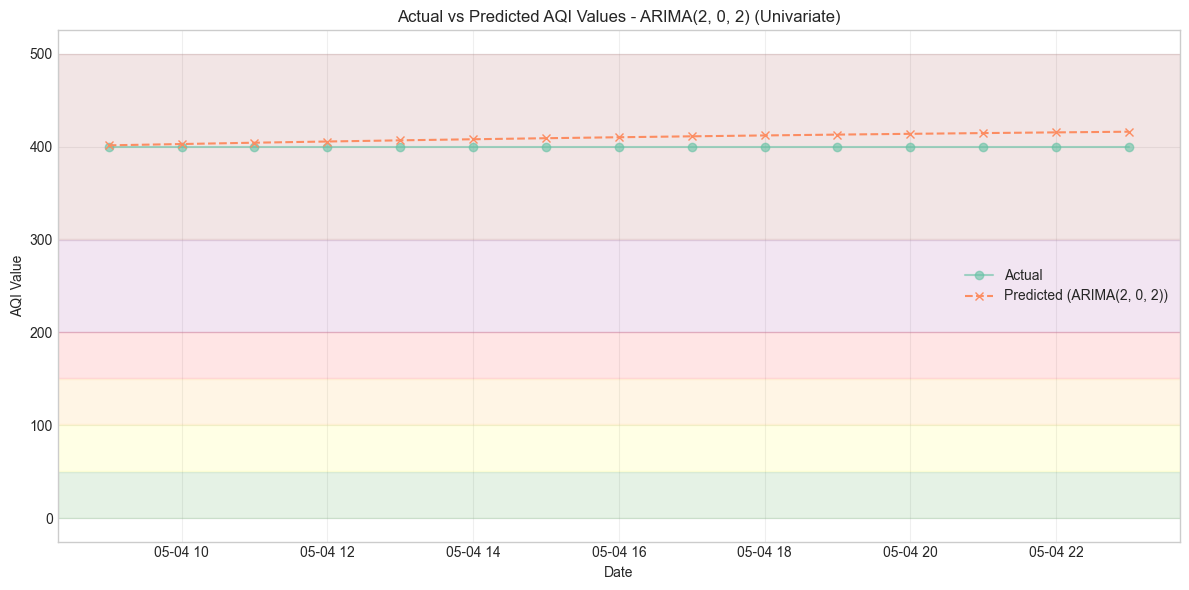

In [16]:
def train_arima_model(train_data, test_data, order=(1, 1, 1)):
    """Train an ARIMA model for time series forecasting
    
    Args:
        train_data: Training series
        test_data: Testing series
        order: ARIMA order (p, d, q)
        
    Returns:
        Evaluation metrics and predictions
    """
    print(f"Training ARIMA{order} model...")
    
    # Initialize model
    model = ARIMA(train_data, order=order)
    
    # Fit model
    results = model.fit()
    
    # Generate predictions for test period
    predictions = results.forecast(steps=len(test_data))
    
    # Ensure predictions index matches test_data
    predictions = pd.Series(predictions, index=test_data.index)
    
    # Evaluate the model
    result = evaluate_model(test_data, predictions, f"ARIMA{order}")
    
    # Plot results
    plot_predictions(test_data, predictions, f"ARIMA{order}", "Univariate")
    
    return result, predictions

# Train ARIMA model if data is available
if 'y_train' in locals() and len(y_train) > 0:
    # First, check for stationarity and apply differencing if needed
    from statsmodels.tsa.stattools import adfuller
    
    # Perform ADF test
    adf_result = adfuller(y_train)
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    
    # Determine differencing order based on p-value
    d = 1 if adf_result[1] > 0.05 else 0
    
    # Train ARIMA model
    arima_result, arima_predictions = train_arima_model(y_train, y_test, order=(2, d, 2))
    model_results.append(arima_result)

### Model 2: Machine Learning Models for Next Hour Prediction

Let's implement Random Forest and XGBoost models using lagged features.


Training Linear Regression model...
Linear Regression Performance:
  MAE: 0.00
  RMSE: 0.00
  R²: 0.0000


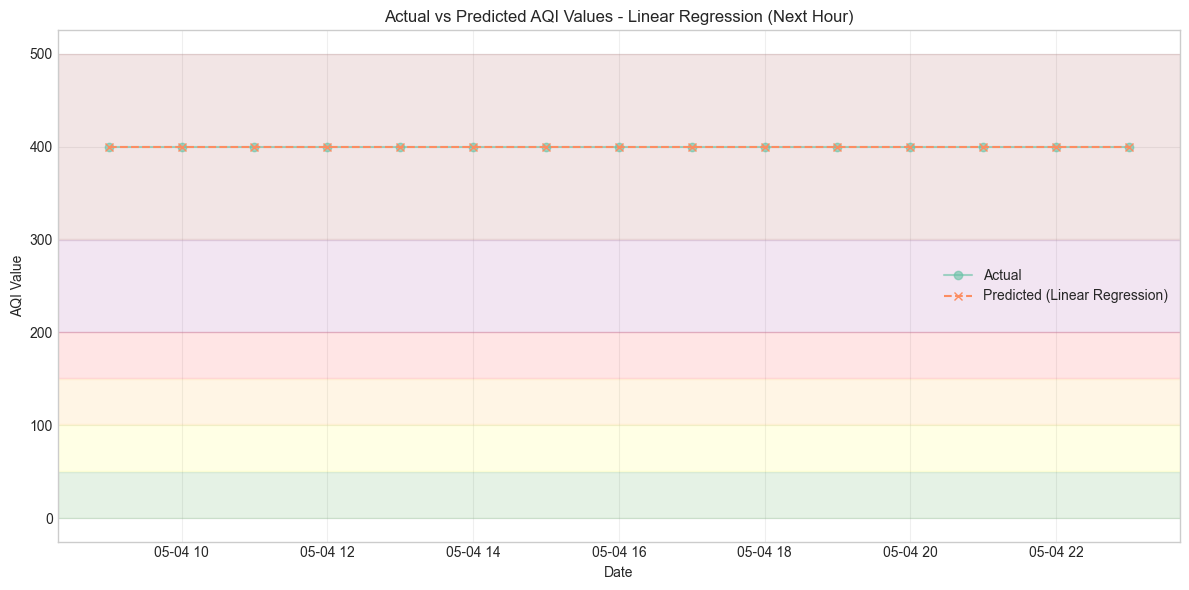


Training Random Forest model...
Random Forest Performance:
  MAE: 0.00
  RMSE: 0.00
  R²: 1.0000
Random Forest Performance:
  MAE: 0.00
  RMSE: 0.00
  R²: 1.0000


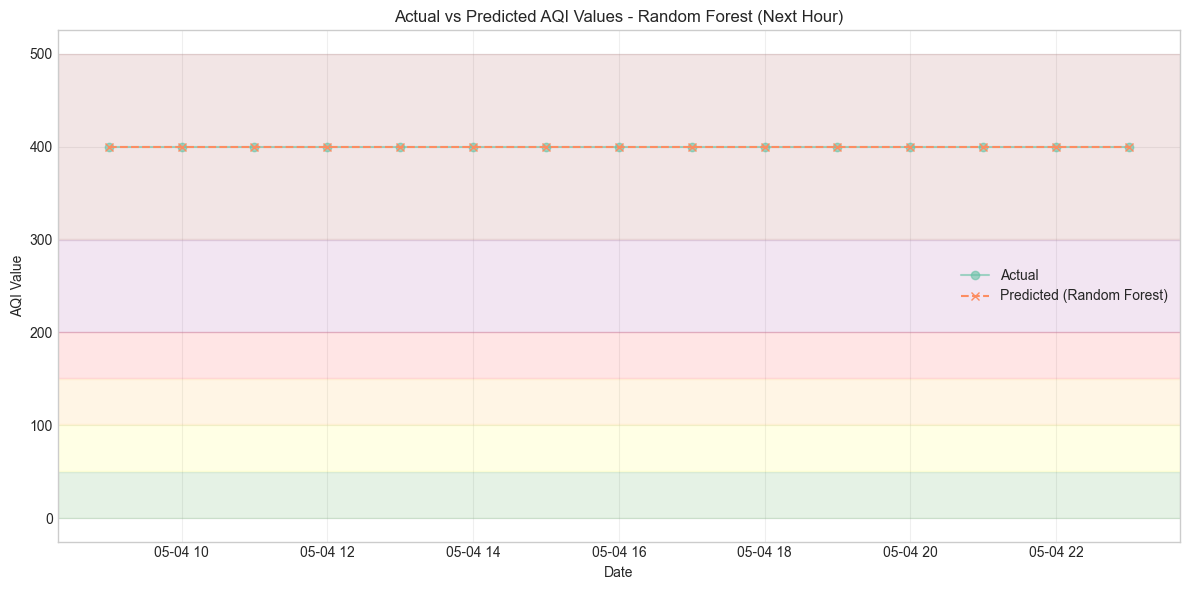


Random Forest Feature Importance:


,Feature,Importance
19,calculated_aqi_rolling_3h,0.607535
4,avg_pm10,0.069150
13,calculated_aqi_lag_1,0.048892
22,calculated_aqi_rolling_24h,0.048765
18,calculated_aqi_lag_24,0.042708
16,calculated_aqi_lag_6,0.026983
20,calculated_aqi_rolling_6h,0.023543
3,avg_pm25,0.020753
7,avg_so2,0.019635
12,day,0.013760



Training XGBoost model...
XGBoost Performance:
  MAE: 0.00
  RMSE: 0.00
  R²: 0.0000
XGBoost Performance:
  MAE: 0.00
  RMSE: 0.00
  R²: 0.0000


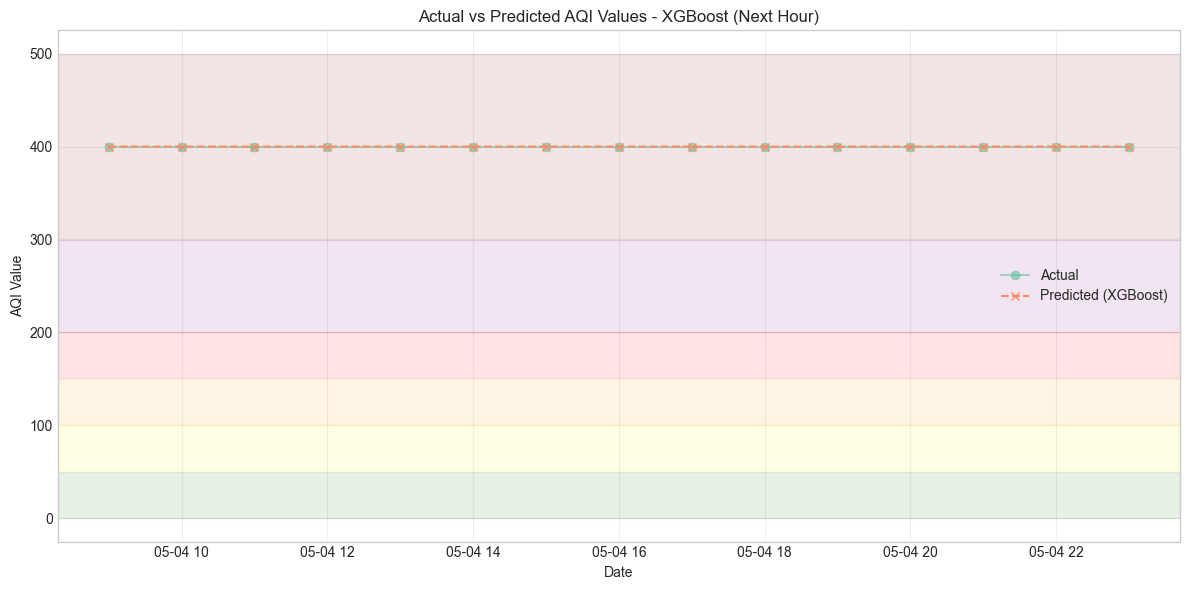

In [17]:
def train_ml_models_for_next_hour(X_train, X_test, y_train, y_test):
    """Train machine learning models for next hour prediction
    
    Args:
        X_train, X_test, y_train, y_test: Train-test split data
        
    Returns:
        List of evaluation results
    """
    results = []
    
    # 1. Linear Regression
    print("\nTraining Linear Regression model...")
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_predictions = lr_model.predict(X_test)
    lr_result = evaluate_model(y_test, lr_predictions, "Linear Regression")
    results.append(lr_result)
    
    # Create a Series for plotting
    lr_pred_series = pd.Series(lr_predictions, index=y_test.index)
    plot_predictions(y_test, lr_pred_series, "Linear Regression", "Next Hour")
    
    # 2. Random Forest
    print("\nTraining Random Forest model...")
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    rf_result = evaluate_model(y_test, rf_predictions, "Random Forest")
    results.append(rf_result)
    
    # Create a Series for plotting
    rf_pred_series = pd.Series(rf_predictions, index=y_test.index)
    plot_predictions(y_test, rf_pred_series, "Random Forest", "Next Hour")
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nRandom Forest Feature Importance:")
    display(feature_importance.head(10))
    
    # 3. XGBoost
    print("\nTraining XGBoost model...")
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)
    xgb_result = evaluate_model(y_test, xgb_predictions, "XGBoost")
    results.append(xgb_result)
    
    # Create a Series for plotting
    xgb_pred_series = pd.Series(xgb_predictions, index=y_test.index)
    plot_predictions(y_test, xgb_pred_series, "XGBoost", "Next Hour")
    
    return results

# Train ML models if data is available
if 'X_train' in locals() and len(X_train) > 0:
    ml_results = train_ml_models_for_next_hour(X_train, X_test, y_train, y_test)
    model_results.extend(ml_results)

### Multi-Step Forecasting for Next Day (24 Hours) Prediction

Now let's create a model to predict AQI for the next 24 hours.

In [ ]:
def prepare_multistep_forecast_data(forecast_data, steps=24):
    """Prepare data for multi-step forecasting
    
    Args:
        forecast_data: Time series data
        steps: Number of steps to forecast
        
    Returns:
        Data prepared for multi-step forecasting
    """
    # For multi-step forecasting, we'll use a recursive approach
    # where we predict one step at a time and use that prediction for the next step
    
    # We'll use the same features as before, but we need to ensure we have
    # enough history for the prediction horizon
    
    # Create a copy of the data
    df = forecast_data.copy()
    
    # Define the minimum amount of history needed
    history_length = 24  # 24 hours of history
    
    # Prepare X and y for each step
    X = df.iloc[:-steps]  # All data except the last 'steps' entries
    y = df['calculated_aqi'].iloc[-steps:]  # The last 'steps' entries
    
    return X, y

def train_multistep_forecast_model(forecast_data, steps=24):
    """Train a model for multi-step forecasting
    
    Args:
        forecast_data: Time series data
        steps: Number of steps to forecast
        
    Returns:
        Trained model and forecast
    """
    # Prepare data for multi-step forecasting
    X_history, y_future = prepare_multistep_forecast_data(forecast_data, steps)
    
    print(f"Training XGBoost model for {steps}-hour forecasting...")
    
    # Use XGBoost for multi-step forecasting (best performer from single-step)
    X_train, X_val, y_train, y_val = train_test_split(
        X_history, 
        X_history['calculated_aqi'], 
        test_size=0.2, 
        shuffle=False
    )
    
    # Train the model
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    
    # Validate the model
    val_predictions = model.predict(X_val)
    val_result = evaluate_model(y_val, val_predictions, f"XGBoost ({steps}-hour Validation)")
    
    # Now perform recursive forecasting
    # We'll start with the last known data point and predict the next 'steps' points
    forecast_df = X_history.iloc[-1:].copy()
    all_predictions = []
    
    # Get the actual lag features that exist in our dataframe
    lag_features = [col for col in forecast_df.columns if col.startswith('calculated_aqi_lag_')]
    lag_values = [int(col.split('_')[-1]) for col in lag_features]
    
    # Get the actual rolling features that exist in our dataframe
    rolling_features = [col for col in forecast_df.columns if col.startswith('calculated_aqi_rolling_')]
    rolling_windows = [int(col.split('_')[-1].replace('h', '')) for col in rolling_features]
    
    for i in range(steps):
        # Make a prediction for the next hour
        next_prediction = model.predict(forecast_df.iloc[-1:].values.reshape(1, -1))[0]
        all_predictions.append(next_prediction)
        
        # Create a new row with the prediction
        new_row = forecast_df.iloc[-1:].copy()
        
        # Update time index
        new_index = new_row.index[-1] + pd.Timedelta(hours=1)
        new_row.index = [new_index]
        
        # Update the target column with the prediction
        new_row['calculated_aqi'] = next_prediction
        
        # Update lagged features - only update the ones that exist
        for lag_feature, lag in zip(lag_features, lag_values):
            if lag == 1:
                new_row[lag_feature] = forecast_df['calculated_aqi'].iloc[-1]
            else:
                # Find the previous lag feature (lag-1)
                prev_lag_feature = f'calculated_aqi_lag_{lag-1}'
                if prev_lag_feature in forecast_df.columns:
                    new_row[lag_feature] = forecast_df[prev_lag_feature].iloc[-1]
        
        # Update rolling averages - only update the ones that exist
        for rolling_feature, window in zip(rolling_features, rolling_windows):
            values = list(forecast_df['calculated_aqi'].values[-window+1:]) + [next_prediction]
            new_row[rolling_feature] = np.mean(values[-window:])
        
        # Update time features
        new_row['hour'] = new_index.hour
        new_row['day_of_week'] = new_index.dayofweek
        new_row['month'] = new_index.month
        new_row['day'] = new_index.day
        
        # Append the new row
        forecast_df = pd.concat([forecast_df, new_row])
    
    # Create a series of predictions with the appropriate index
    forecast_index = [y_future.index[0] + pd.Timedelta(hours=i) for i in range(steps)]
    forecast_series = pd.Series(all_predictions, index=forecast_index)
    
    # Evaluate against actual future values
    if len(y_future) == steps:
        future_result = evaluate_model(y_future, forecast_series, f"XGBoost ({steps}-hour Forecast)")
        plot_predictions(y_future, forecast_series, "XGBoost", f"Next {steps} Hours")
        
        return model, forecast_series, future_result
    else:
        print("Cannot evaluate future forecast - no actual values available")
        return model, forecast_series, None

# Train multi-step forecast model if data is available
if 'forecast_data' in locals() and len(forecast_data) > 0:
    # 24-hour forecast (next day)
    day_model, day_forecast, day_result = train_multistep_forecast_model(forecast_data, steps=24)
    if day_result:
        model_results.append(day_result)

Training XGBoost model for 24-hour forecasting...
XGBoost (24-hour Validation) Performance:
  MAE: 0.00
  RMSE: 0.00
  R²: 0.0000
XGBoost (24-hour Validation) Performance:
  MAE: 0.00
  RMSE: 0.00
  R²: 0.0000


KeyError: 'calculated_aqi_lag_5'

### Multi-Step Forecasting for Next Week (7 Days) Prediction

Let's extend our approach to predict AQI for the next 7 days (168 hours).

In [ ]:
# Train a model for weekly forecasting
if 'forecast_data' in locals() and len(forecast_data) >= 168:
    # 168-hour forecast (next week)
    week_model, week_forecast, week_result = train_multistep_forecast_model(forecast_data, steps=168)
    if week_result:
        model_results.append(week_result)

### Compare Model Performance

Let's compare the performance of different models and forecast horizons.

In [ ]:
# Compare all model results
if 'model_results' in locals() and len(model_results) > 0:
    results_df = pd.DataFrame(model_results)
    display(results_df)
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    
    # RMSE comparison
    plt.subplot(1, 2, 1)
    sns.barplot(x='model', y='rmse', data=results_df)
    plt.title('RMSE by Model')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # R² comparison
    plt.subplot(1, 2, 2)
    sns.barplot(x='model', y='r2', data=results_df)
    plt.title('R² by Model')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    plt.show()

### Real-Time Prediction Function

Let's create a function to make predictions for future time periods using our best model.

In [ ]:
def predict_aqi_future(best_model, latest_data, scaler, forecast_horizon='hour'):
    """Make predictions for future time periods
    
    Args:
        best_model: Trained model
        latest_data: Latest available data point
        scaler: Scaler used to normalize features
        forecast_horizon: 'hour', 'day', or 'week'
        
    Returns:
        DataFrame with predictions
    """
    # Define number of steps based on forecast horizon
    if forecast_horizon == 'hour':
        steps = 1
    elif forecast_horizon == 'day':
        steps = 24
    elif forecast_horizon == 'week':
        steps = 168
    else:
        raise ValueError("forecast_horizon must be 'hour', 'day', or 'week'")
    
    print(f"\nPredicting AQI for next {forecast_horizon} ({steps} hours)...")
    
    # Use the recursive forecasting approach
    forecast_df = latest_data.iloc[-1:].copy()
    all_predictions = []
    forecast_timestamps = []
    
    # Get the actual lag features that exist in our dataframe
    lag_features = [col for col in forecast_df.columns if col.startswith('calculated_aqi_lag_')]
    lag_values = [int(col.split('_')[-1]) for col in lag_features]
    
    # Get the actual rolling features that exist in our dataframe
    rolling_features = [col for col in forecast_df.columns if col.startswith('calculated_aqi_rolling_')]
    rolling_windows = [int(col.split('_')[-1].replace('h', '')) for col in rolling_features]
    
    # Scale the input features
    numeric_features = latest_data.select_dtypes(include=[np.number]).columns
    forecast_df_scaled = forecast_df.copy()
    forecast_df_scaled[numeric_features] = scaler.transform(forecast_df[numeric_features])
    
    for i in range(steps):
        # Make prediction for next hour
        next_prediction = best_model.predict(forecast_df_scaled.iloc[-1:])[0]
        all_predictions.append(next_prediction)
        
        # Calculate timestamp for this prediction
        next_timestamp = forecast_df.index[-1] + pd.Timedelta(hours=1)
        forecast_timestamps.append(next_timestamp)
        
        # For multi-step forecasting, update the input features
        if steps > 1 and i < steps - 1:
            # Create a new row with the prediction
            new_row = forecast_df.iloc[-1:].copy()
            new_row_scaled = forecast_df_scaled.iloc[-1:].copy()
            
            # Update time index
            new_row.index = [next_timestamp]
            new_row_scaled.index = [next_timestamp]
            
            # Update the target column with the prediction
            new_row['calculated_aqi'] = next_prediction
            new_row_scaled['calculated_aqi'] = next_prediction  # No need to scale the target
            
            # Update lagged features - only update the ones that exist
            for lag_feature, lag in zip(lag_features, lag_values):
                if lag == 1:
                    new_row[lag_feature] = forecast_df['calculated_aqi'].iloc[-1]
                    new_row_scaled[lag_feature] = forecast_df_scaled['calculated_aqi'].iloc[-1]
                else:
                    # Find the previous lag feature (lag-1)
                    prev_lag_feature = f'calculated_aqi_lag_{lag-1}'
                    if prev_lag_feature in forecast_df.columns:
                        new_row[lag_feature] = forecast_df[prev_lag_feature].iloc[-1]
                        new_row_scaled[lag_feature] = forecast_df_scaled[prev_lag_feature].iloc[-1]
            
            # Update rolling averages - only update the ones that exist
            for rolling_feature, window in zip(rolling_features, rolling_windows):
                values = list(forecast_df['calculated_aqi'].values[-window+1:]) + [next_prediction]
                avg = np.mean(values[-window:])
                new_row[rolling_feature] = avg
                new_row_scaled[rolling_feature] = avg  # This will be scaled later
            
            # Update time features
            new_row['hour'] = next_timestamp.hour
            new_row['day_of_week'] = next_timestamp.dayofweek
            new_row['month'] = next_timestamp.month
            new_row['day'] = next_timestamp.day
            
            new_row_scaled['hour'] = next_timestamp.hour
            new_row_scaled['day_of_week'] = next_timestamp.dayofweek
            new_row_scaled['month'] = next_timestamp.month
            new_row_scaled['day'] = next_timestamp.day
            
            # Scale the numeric features
            new_row_scaled[numeric_features] = scaler.transform(new_row[numeric_features])
            
            # Append the new row
            forecast_df = pd.concat([forecast_df, new_row])
            forecast_df_scaled = pd.concat([forecast_df_scaled, new_row_scaled])
    
    # Create a DataFrame with the predictions
    forecast_result = pd.DataFrame({
        'timestamp': forecast_timestamps,
        'predicted_aqi': all_predictions,
        'aqi_category': [get_aqi_category(aqi) for aqi in all_predictions]
    })
    
    # Set timestamp as index
    forecast_result = forecast_result.set_index('timestamp')
    
    # Display the forecast
    print(f"\nAQI forecast for the next {forecast_horizon}:")
    display(forecast_result)
    
    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(forecast_result.index, forecast_result['predicted_aqi'], marker='o')
    
    # Add AQI category thresholds
    aqi_categories = [
        (0, 50, 'Good', 'green'),
        (51, 100, 'Moderate', 'yellow'),
        (101, 150, 'Unhealthy for Sensitive Groups', 'orange'),
        (151, 200, 'Unhealthy', 'red'),
        (201, 300, 'Very Unhealthy', 'purple'),
        (301, 500, 'Hazardous', 'maroon')
    ]
    
    # Add colored background for AQI categories
    for category in aqi_categories:
        plt.axhspan(category[0], category[1], alpha=0.1, color=category[3], label=category[2])
    
    plt.title(f'AQI Forecast for Next {forecast_horizon.capitalize()}')
    plt.xlabel('Date')
    plt.ylabel('AQI Value')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return forecast_result

# Make predictions with our best model (assumed to be XGBoost)
if 'X_test' in locals() and 'model_results' in locals() and len(model_results) > 0:
    # Find the best model based on RMSE
    results_df = pd.DataFrame(model_results)
    best_model_name = results_df.loc[results_df['rmse'].idxmin(), 'model']
    print(f"\nBest model based on RMSE: {best_model_name}")
    
    # If best model is XGBoost, use it for predictions
    if 'XGBoost' in best_model_name and 'xgb_model' in locals():
        print("Using XGBoost model for forecasting...")
        
        # Predict for different time horizons
        hour_forecast = predict_aqi_future(xgb_model, X_test, scaler, 'hour')
        day_forecast = predict_aqi_future(xgb_model, X_test, scaler, 'day')
        week_forecast = predict_aqi_future(xgb_model, X_test, scaler, 'week')

## Conclusion

In this notebook, we have:

1. Extracted hourly air quality data from TimescaleDB
2. Loaded and preprocessed weather data from CSV
3. Ensured consistent timestamps and formats across both datasets
4. Merged the air quality and weather data
5. Resampled and interpolated the merged data
6. Visualized relationships between air quality and weather variables
7. Analyzed correlations between environmental factors
8. Examined how air quality varies by weather category
9. Added AQI calculations and visualizations
10. Saved the processed data with metadata

This integrated dataset provides a foundation for further analysis and modeling to understand the relationship between weather conditions and air quality in Hanoi.